<a href="https://colab.research.google.com/github/connor-verheyen/COVID19_IndoorRH/blob/main/supplementary_analysis/Supplementary_Section_05__Analyzing_Regional_Variability_In_Tropics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries 

import pandas as pd
import numpy as np
import scipy as sp 
import math
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Set seaborn plotting defaults
sns.set(context='talk', font_scale=0.9, style='whitegrid', palette='Blues_d')

In [ ]:
# Import Files 
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/7DaySmooth_ALLVars_Dataset_2020_08_10_GE50_Deaths.csv'

df7all = pd.read_csv(filename) #df7all = pd.read_excel('7DaySmooth_ALLVars_Dataset_2020_08_10_GE50_Deaths.xlsx')

# Drop unnecessary index columns 
df7all.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
# Tropic of Cancer is located at 23.5 degrees north of the equator and runs through Mexico, the Bahamas, Egypt, Saudi Arabia, India, and southern China
# The Tropic of Capricorn lies at 23.5 degrees south of the equator and runs through Australia, Chile, southern Brazil, and northern South Africa

upper_lat_bound = 23.5; lower_lat_bound = -23.5 

n_hem = df7all[df7all['Lat']>upper_lat_bound]
s_hem = df7all[df7all['Lat']<lower_lat_bound]
trop  = df7all[(df7all['Lat']<upper_lat_bound) & (df7all['Lat']>lower_lat_bound)]

n_trop = df7all[(df7all['Lat']<upper_lat_bound) & (df7all['Lat']>0)]
s_trop = df7all[(df7all['Lat']>lower_lat_bound) & (df7all['Lat']<0)]

df7all.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else 's_hem' if country_name in s_hem['Country'].unique() else 'n_trop' if country_name in n_trop['Country'].unique() else 's_trop' for country_name in df7all.loc[:,'Country']]

In [ ]:
# Set seaborn plotting style 
sns.set(context='talk', font_scale=0.9, style='ticks', palette='Blues_d')

In [ ]:
# Function to create lags of a given variable 

def make_lags(dataframe,merging_var,variable,num_lags):
  df = dataframe[['Country',merging_var,variable]].copy() # Make a copy of the country (for grouping) and the variable to be lagged  

  for i in range(1,num_lags+1):
    df[variable+'_lag{}'.format(i)] = df.groupby('Country')[variable].shift(i) # Create all of the lags of the given input variable 

  return df

# # Test run the function 
# make_lags(df,'Days From 5th Death','IndoorRH_pct',28)

In [ ]:
# Function to create a dataframe with lagged versions of the variable and the actual outbreak metrics 

def lagged_var_df(dataframe,merging_var,variable,num_lags,COVIDstats):

  df = dataframe.copy()

  outcomes = df[COVIDstats]

  lagged_variables = make_lags(dataframe,merging_var,variable,num_lags)

  merged = lagged_variables.merge(right=outcomes,how='left',on=['Country',merging_var])

  return merged


In [ ]:
# Function for changing seaborn barplot width 

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [ ]:
def quantizer(dataframe, first_day, last_day, qlevels, countries, retbins):

  # Dataframe to use for plotting -> Set lower and upper bound for days from 5th death, only use the selected list of countries (could be all, n_hem, s_hem, trop, or for a given month)
  df = dataframe[(dataframe['Days From 5th Death'].ge(first_day)) & (dataframe['Days From 5th Death'].le(last_day)) & (dataframe['Country'].isin(countries))].copy()

  if retbins == True: # return the bin ranges and label each category with the bin range 
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
  
  else: # don't retun the bin ranges and label each category with an integer
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,duplicates='drop',labels=False).astype('category')

  return df

In [ ]:
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

lagged_df7all = lagged_var_df(df7all,'Days From 5th Death','IndoorRH_pct',28,COVIDstats)

# Discretize the treatment  
bins = [0,40,60,100] # How to break up the continuous variable (0-40),(40-60),(60-100)
labels = [0,1,2] # How to label the bins 
lagged_df7all['quantized_IndRH'] = pd.cut(lagged_df7all['IndoorRH_pct'],bins=bins,labels=labels) # Use cut to break up the continuous data 
lagged_df7all['quantized_IndRH_lag7'] = pd.cut(lagged_df7all['IndoorRH_pct_lag7'],bins=bins,labels=labels) # Use cut to break up the continuous data 
lagged_df7all['quantized_IndRH_lag14'] = pd.cut(lagged_df7all['IndoorRH_pct_lag14'],bins=bins,labels=labels) # Use cut to break up the continuous data 
lagged_df7all['quantized_IndRH_lag21'] = pd.cut(lagged_df7all['IndoorRH_pct_lag21'],bins=bins,labels=labels) # Use cut to break up the continuous data 

# Binarize the treatment (so <40 and >60 are untreated, 40-60 are treated) 
binary_treatment = lagged_df7all.copy() # Copy the dataframe 
# Turn discretized treatment (with 3 ordinal levels) into binarized treatment (on or off) 
binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']] = binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']].replace(2,0)

# # Binarize the outbreak metrics 
# first_day = 0; last_day = 120; qlevels=2
# lagged_df7all_q = quantizer(dataframe=lagged_df7all, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=lagged_df7all['Country'].unique(), retbins=False)
# binary_treatment_q = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=lagged_df7all['Country'].unique(), retbins=False)

In [ ]:
import statsmodels.api as sm

def oddsratio(dataset,outcome,treatment):
  
  data = dataset[[outcome,treatment]].copy() # Copy dataset 

  contig_table = pd.crosstab(data[outcome],data[treatment]).iloc[::-1,] # Make a 2x2 contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 
  #print(contig_table)

  table = sm.stats.Table2x2(np.asarray(contig_table)) # Use statsmodels to turn the contingency table into a special 2x2 table for further statsmodels calculations 
  #print(table)

  #table=sm.stats.Table2x2.from_data(data) # Make a contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 

  odds_badoutcome_notreatment = contig_table.iloc[0,0]/contig_table.iloc[1,0] # Odds of having a worse outcome (e.g. more deaths) WITHOUT treatment (e.g. RH<40% or RH>60%) 
  odds_badoutcome_withtreatment = contig_table.iloc[0,1]/contig_table.iloc[1,1] # Odds of having a worse outcome (e.g. more deaths) WITH treatment (e.g. RH 40%-60%) 

  odds_ratio = table.oddsratio # Odds ratio (ratio of odds_badoutcome_notreatment to odds_badoutcome_withtreatment) -> how much more likely are you to have a bad outcome if you don't receive the treatment 
  LCB = table.oddsratio_confint()[0] # Lower 95% confidence boundary
  UCB = table.oddsratio_confint()[1] # Upper 95% confidence boundary 
  pval = table.oddsratio_pvalue() # p-value for a hypothesis test about the odds ratio

  return odds_badoutcome_notreatment, odds_badoutcome_withtreatment, odds_ratio, LCB, UCB, pval 

# To run function... 
# oddsratio(dataset=treat_total,outcome='new_cases_Qlevels',treatment='quantized_IndRH')

In [ ]:
#np.append(n_trop['Country'].unique(), s_trop['Country'].unique())

array(['Burkina Faso', 'Cameroon', 'Central African Republic', 'Chad',
       'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Cuba', 'Djibouti',
       'Dominican Republic', 'El Salvador', 'Equatorial Guinea',
       'Ethiopia', 'Ghana', 'Guatemala', 'Haiti', 'Honduras', 'India',
       'Liberia', 'Malaysia', 'Mali', 'Mauritania', 'Nicaragua', 'Niger',
       'Nigeria', 'Oman', 'Panama', 'Philippines', 'Senegal',
       'Sierra Leone', 'Somalia', 'Sudan', 'Thailand',
       'United Arab Emirates', 'Venezuela', 'Yemen', 'Angola', 'Bolivia',
       'Brazil', 'Congo (Kinshasa)', 'Ecuador', 'Gabon', 'Indonesia',
       'Kenya', 'Madagascar', 'Malawi', 'Paraguay', 'Peru', 'Zambia',
       'Zimbabwe'], dtype=object)

In [ ]:
# Compute odds ratios by region (All Countries, NH, SH, Trop) 

first_day = 0; last_day = 120; qlevels=2
#treat_total = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=df7all['Country'].unique(), retbins=False).dropna()
#treat_nhem = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_hem['Country'].unique(), retbins=False).dropna()
treat_trop = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=np.append(n_trop['Country'].unique(), s_trop['Country'].unique()), retbins=False).dropna()
treat_ntrop = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=n_trop['Country'].unique(), retbins=False).dropna()
treat_strop = quantizer(dataframe=binary_treatment, first_day=first_day, last_day=last_day, qlevels=qlevels, countries=s_trop['Country'].unique(), retbins=False).dropna()


quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
dataset_list = [treat_trop, treat_ntrop,treat_strop]
dataset_names = ['Tro','NTro','STro']

level3 = []
for outcome in quantized_outcomes: 
  level2 = []
  for humidity in quantized_humidities: 
    level1 = [] # Empty list to store each output from the primary calculations
    for dset in dataset_list: 
      computeOR = oddsratio(dataset=dset,outcome=outcome,treatment=humidity) # Compute the odds for NO treatment odds for WITH treatment, odds ratio, LCL, UCL, and pval
      level1.append(computeOR) # Append the output tuple to the list 
    df_level1 = pd.DataFrame(level1, columns =['oddsbad_NO_treatment', 'oddsbad_WITH_treatment', 'odds_ratio','LCL','UCL','pval'],index=dataset_names) # Put all outputs into a labeled dataframe
    level2.append(df_level1) # Put the labeled output dataframe (calculations for each region) into the list of dataframes in level 2 (calculations for each time-lagged humidity value) 
  df_level2 = pd.concat(level2,keys=quantized_humidities) # Put all dfs into a multi-index dataframe 
  level3.append(df_level2) # Put the multi-index dataframes (calcs for each region and each time-lag) into the list of dataframes in level 3(calculations for each COVID-19 outbreak metric) 
df_ORs_byregion = pd.concat(level3, keys=quantized_outcomes) # Put all of the multi-index dataframes into a final multi-index dataframe 
print('Done')

Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

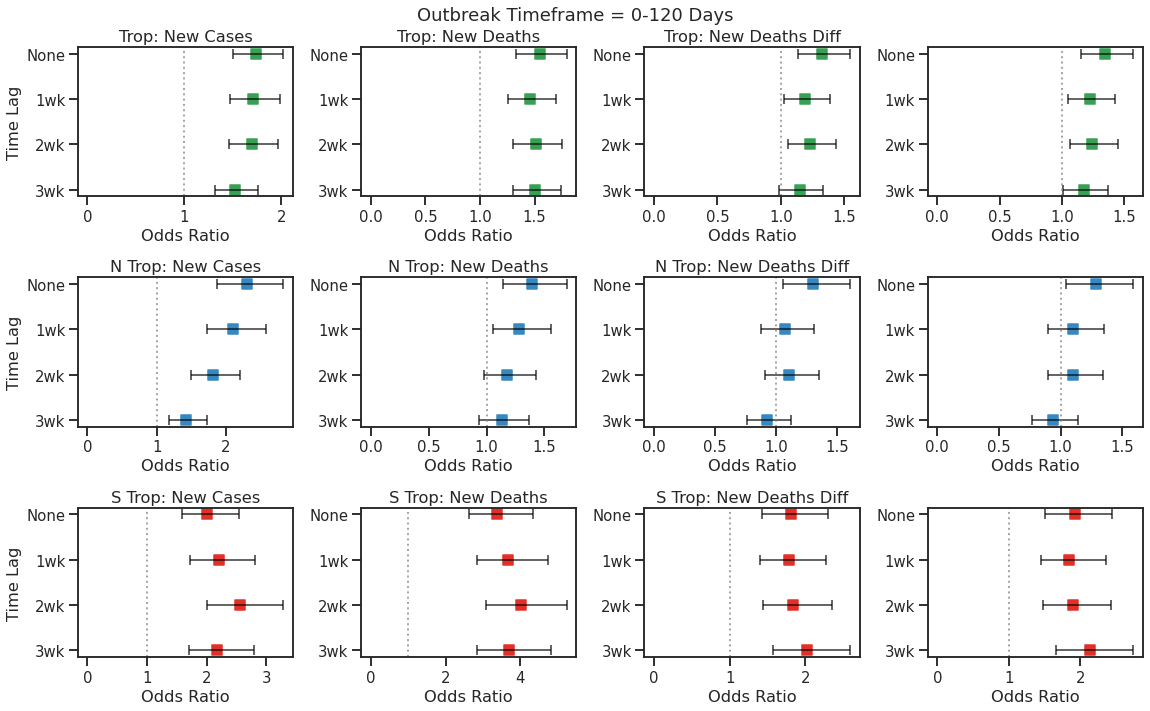

In [ ]:
# Set up the plotting 
quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
dataset_names = ['Tro','NTro','STro']

rows = len(dataset_names); cols = len(quantized_outcomes); fig,ax=plt.subplots(rows,cols,figsize=(16,10))
points = []; lines=[]
# Go through each quantized outbreak metric and make plots 
for col in range(0,cols):
  for lag in range(len(quantized_humidities)):
    for region in range(len(dataset_names)):
      data_for_plotting = df_ORs_byregion.loc[(quantized_outcomes[col],quantized_humidities[lag],dataset_names[region])]
      ax[region,col].errorbar(x=data_for_plotting['odds_ratio'],y=lag,xerr=np.array([data_for_plotting['odds_ratio']-data_for_plotting['LCL'],data_for_plotting['UCL']-data_for_plotting['odds_ratio']]).reshape(-1,1),capsize=5,capthick=2,elinewidth=2,ecolor='k',alpha=0.6,dash_capstyle='butt')
      points.append(ax[region,col].scatter(data_for_plotting['odds_ratio'],lag,marker='s',color='k',alpha=1,s=120))
      ax[region,col].set_yticks(range(0,len(quantized_humidities)))
      ax[region,col].set_yticklabels(['None','1wk','2wk','3wk'])

ax[0,0].set_title('Trop: New Cases'); ax[1,0].set_title('N Trop: New Cases'); ax[2,0].set_title('S Trop: New Cases'); #ax[3,0].set_title('STro: New Cases')
ax[0,1].set_title('Trop: New Deaths'); ax[1,1].set_title('N Trop: New Deaths'); ax[2,1].set_title('S Trop: New Deaths'); #ax[3,1].set_title('STro: New Deaths')
ax[0,2].set_title('Trop: New Deaths Diff'); ax[1,2].set_title('N Trop: New Deaths Diff'); ax[2,2].set_title('S Trop: New Deaths Diff'); #ax[3,2].set_title('STro: New Deaths Diff')
#ax[0,3].set_title('NH: New Deaths % Chg'); ax[1,3].set_title('SH: New Deaths % Chg'); ax[2,3].set_title('NTro: New Deaths % Chg'); ax[3,3].set_title('STro: New Deaths % Chg')

[ax.set_xlabel('Odds Ratio') for ax in plt.gcf().axes]; [ax[r,0].set_ylabel('Time Lag') for r in np.arange(0,3)]

[points[i].set_color(sns.color_palette(palette='Greens_d',n_colors=1)) for i in range(0,48,3)]
[points[i].set_color(sns.color_palette(palette='Blues_d',n_colors=1)) for i in range(1,49,3)]
[points[i].set_color(sns.color_palette(palette='Reds_d',n_colors=1)) for i in range(2,50,3)]
#[points[i].set_color(sns.color_palette(palette='Reds_d',n_colors=1)) for i in range(3,67,4)]

[ax.axvline(x=0,color='grey',alpha=0.0,linewidth=0) for ax in plt.gcf().axes]
[ax.axvline(x=1,linestyle=':',color='grey',alpha=0.7,linewidth=2) for ax in plt.gcf().axes]
[ax.invert_yaxis() for ax in plt.gcf().axes]
fig.suptitle(('Outbreak Timeframe = {firstday}-{lastday} Days').format(firstday=first_day,lastday=last_day), fontsize=18)
fig.tight_layout(pad=0.5,h_pad=1,w_pad=1,rect=[0, 0, 1, 0.96])

# from google.colab import files
# filename = ('Supplemental_SensitivityAnalysis_OddsRatios_NorthTropics_SouthTropics.png').format(firstday=first_day,lastday=last_day)
# fig.savefig(filename, dpi=500)
# files.download(filename) 

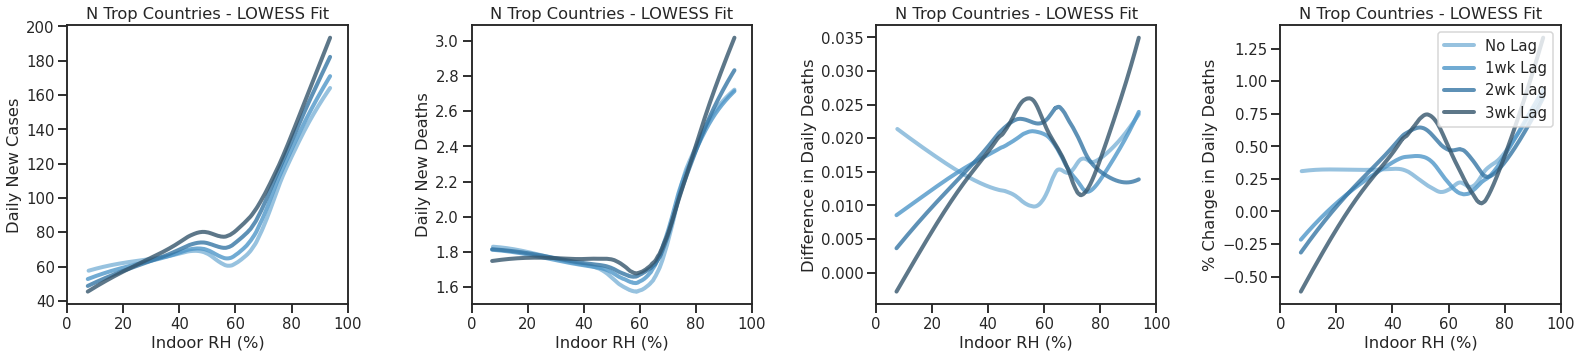

In [ ]:
ntrop_forplot = lagged_df7all[(lagged_df7all['Days From 5th Death']>=0) & (lagged_df7all['Country'].isin(n_trop['Country'].unique()))]

outcomes = ['new_cases','new_deaths','new_deaths_diff','new_deaths_pctchange']
rows = 1; cols = len(outcomes); fig,ax=plt.subplots(rows,cols,figsize=(22,5))

# Go through each quantized outbreak metric and make plots 
for col in range(0,cols): 
  # LOWESS for n trop countries 
  sns.regplot(x='IndoorRH_pct',y=outcomes[col],data=ntrop_forplot,ax=ax[col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[0])
  sns.regplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=ntrop_forplot,ax=ax[col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[1]) 
  sns.regplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=ntrop_forplot,ax=ax[col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[2])
  sns.regplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=ntrop_forplot,ax=ax[col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[3])

ax[3].legend(loc='upper right')
[ax.set_xlim(0,100) for ax in plt.gcf().axes]

[ax[c].set_xlabel('Indoor RH (%)') for c in np.arange(0,4)]

ax[0].set_ylabel('Daily New Cases') 
ax[1].set_ylabel('Daily New Deaths') 
ax[2].set_ylabel('Difference in Daily Deaths') 
ax[3].set_ylabel('% Change in Daily Deaths')

ax[0].set_title('N Trop Countries - LOWESS Fit')
ax[1].set_title('N Trop Countries - LOWESS Fit')
ax[2].set_title('N Trop Countries - LOWESS Fit')
ax[3].set_title('N Trop Countries - LOWESS Fit')

fig.tight_layout(pad=0.5,h_pad=1,w_pad=2)

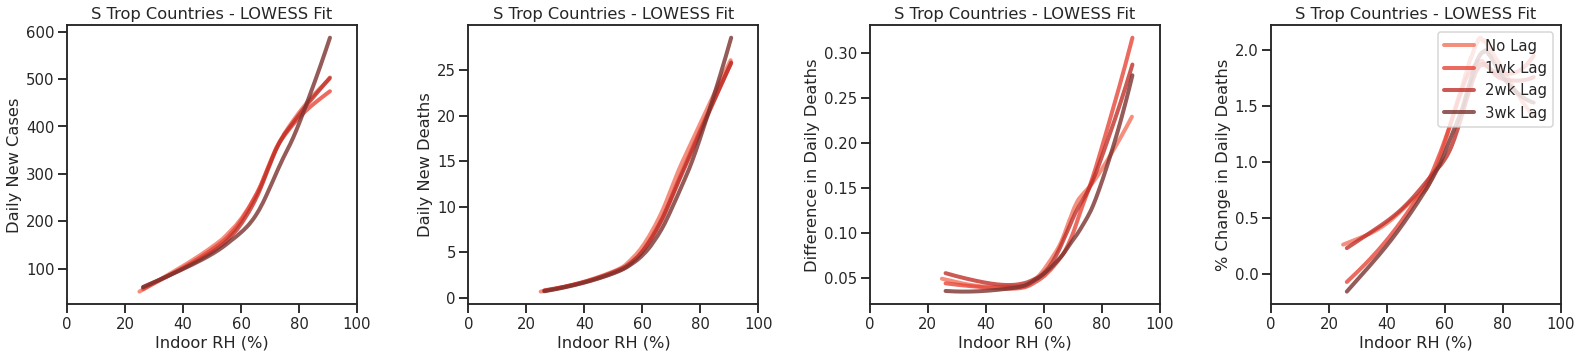

In [ ]:
strop_forplot = lagged_df7all[(lagged_df7all['Days From 5th Death']>=0) & (lagged_df7all['Country'].isin(s_trop['Country'].unique()))]

outcomes = ['new_cases','new_deaths','new_deaths_diff','new_deaths_pctchange']
rows = 1; cols = len(outcomes); fig,ax=plt.subplots(rows,cols,figsize=(22,5))

# Go through each quantized outbreak metric and make plots 
for col in range(0,cols): 
  # LOWESS for s trop countries 
  sns.regplot(x='IndoorRH_pct',y=outcomes[col],data=strop_forplot,ax=ax[col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[0])
  sns.regplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=strop_forplot,ax=ax[col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[1]) 
  sns.regplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=strop_forplot,ax=ax[col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[2])
  sns.regplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=strop_forplot,ax=ax[col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[3])

ax[3].legend(loc='upper right')
[ax.set_xlim(0,100) for ax in plt.gcf().axes]

[ax[c].set_xlabel('Indoor RH (%)') for c in np.arange(0,4)]

ax[0].set_ylabel('Daily New Cases') 
ax[1].set_ylabel('Daily New Deaths') 
ax[2].set_ylabel('Difference in Daily Deaths') 
ax[3].set_ylabel('% Change in Daily Deaths')

ax[0].set_title('S Trop Countries - LOWESS Fit')
ax[1].set_title('S Trop Countries - LOWESS Fit')
ax[2].set_title('S Trop Countries - LOWESS Fit')
ax[3].set_title('S Trop Countries - LOWESS Fit')

fig.tight_layout(pad=0.5,h_pad=1,w_pad=2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

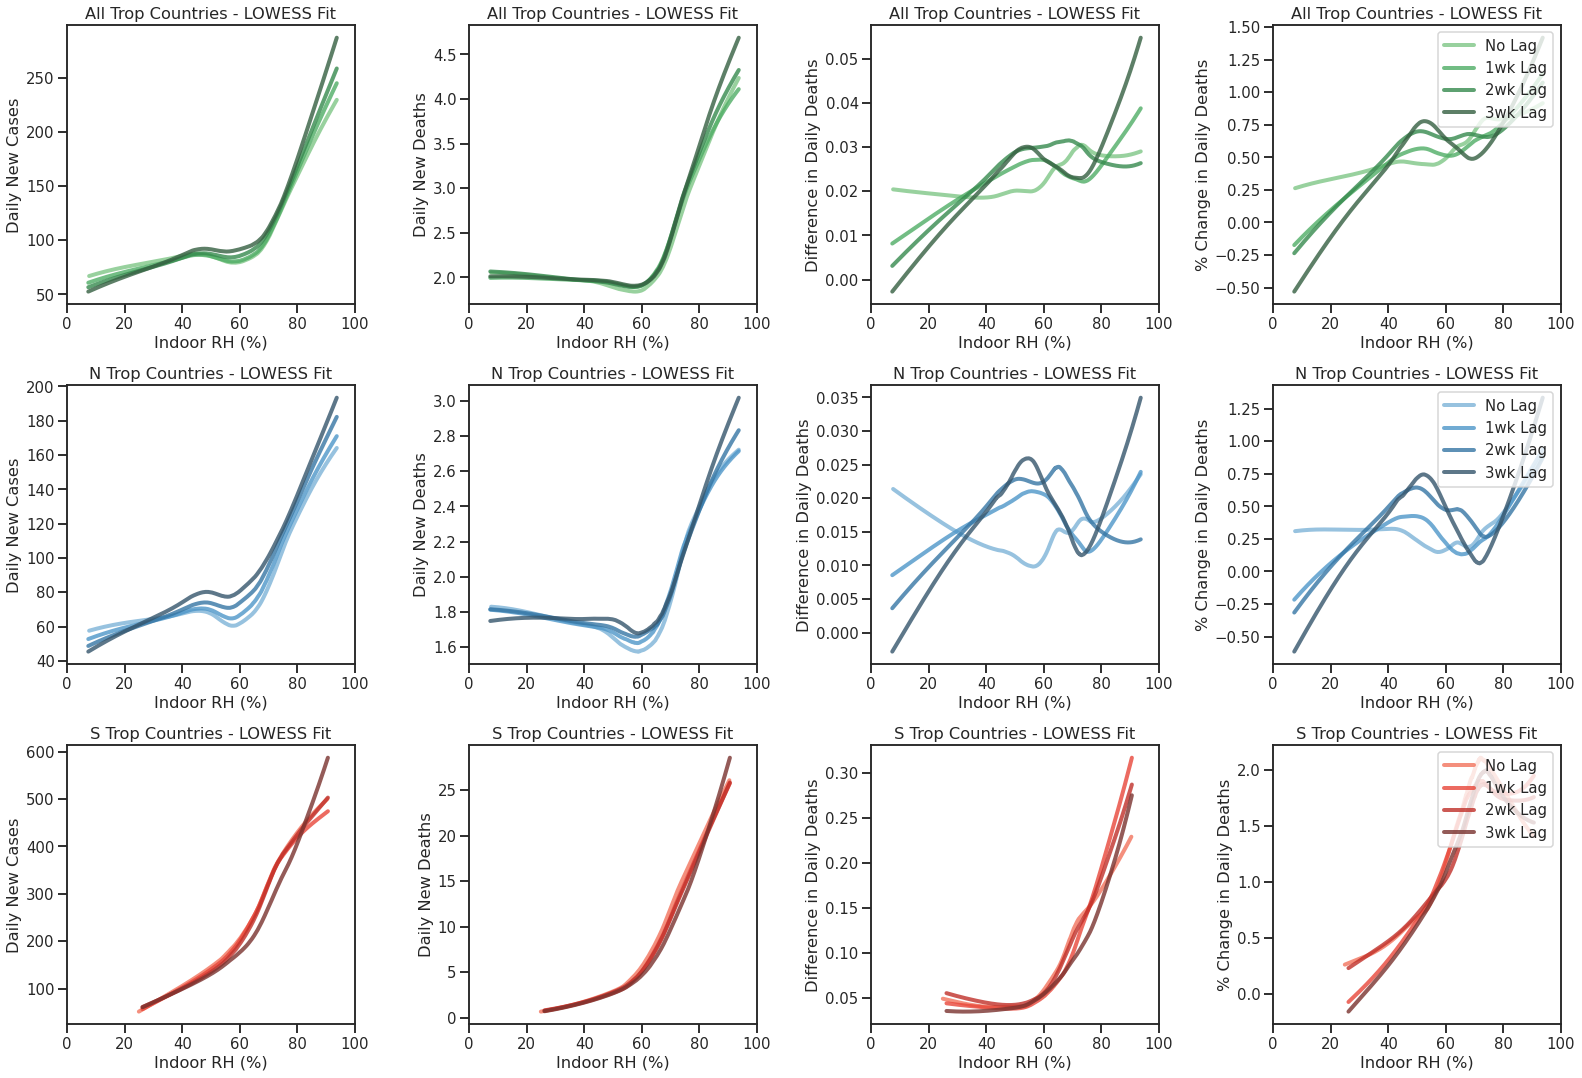

In [ ]:
trop_forplot = lagged_df7all[(lagged_df7all['Days From 5th Death']>=0) & (lagged_df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique())))]
ntrop_forplot = lagged_df7all[(lagged_df7all['Days From 5th Death']>=0) & (lagged_df7all['Country'].isin(n_trop['Country'].unique()))]
strop_forplot = lagged_df7all[(lagged_df7all['Days From 5th Death']>=0) & (lagged_df7all['Country'].isin(s_trop['Country'].unique()))]

outcomes = ['new_cases','new_deaths','new_deaths_diff','new_deaths_pctchange']
rows = 3; cols = len(outcomes); fig,ax=plt.subplots(rows,cols,figsize=(22,15))

# Go through each quantized outbreak metric and make plots 
for col in range(0,cols): 

  # LOWESS for trop countries 
  sns.regplot(x='IndoorRH_pct',y=outcomes[col],data=trop_forplot,ax=ax[0,col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[0])
  sns.regplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=trop_forplot,ax=ax[0,col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[1]) 
  sns.regplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=trop_forplot,ax=ax[0,col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[2])
  sns.regplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=trop_forplot,ax=ax[0,col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Greens_d',n_colors=4)[3])

  # LOWESS for n trop countries 
  sns.regplot(x='IndoorRH_pct',y=outcomes[col],data=ntrop_forplot,ax=ax[1,col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[0])
  sns.regplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=ntrop_forplot,ax=ax[1,col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[1]) 
  sns.regplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=ntrop_forplot,ax=ax[1,col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[2])
  sns.regplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=ntrop_forplot,ax=ax[1,col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Blues_d',n_colors=4)[3])

  # LOWESS for s trop countries 
  sns.regplot(x='IndoorRH_pct',y=outcomes[col],data=strop_forplot,ax=ax[2,col],lowess=True,label='No Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[0])
  sns.regplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=strop_forplot,ax=ax[2,col],lowess=True,label='1wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[1]) 
  sns.regplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=strop_forplot,ax=ax[2,col],lowess=True,label='2wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[2])
  sns.regplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=strop_forplot,ax=ax[2,col],lowess=True,label='3wk Lag',scatter=False,line_kws={'linewidth':4,'alpha':0.8},color=sns.color_palette(palette='Reds_d',n_colors=4)[3])

[ax[r,3].legend(loc='upper right') for r in np.arange(0,3)]
[ax.set_xlim(0,100) for ax in plt.gcf().axes]

[ax[r,0].set_xlabel('Indoor RH (%)') for r in np.arange(0,3)]
[ax[r,1].set_xlabel('Indoor RH (%)') for r in np.arange(0,3)]
[ax[r,2].set_xlabel('Indoor RH (%)') for r in np.arange(0,3)]
[ax[r,3].set_xlabel('Indoor RH (%)') for r in np.arange(0,3)]

[ax[r,0].set_ylabel('Daily New Cases') for r in np.arange(0,3)]
[ax[r,1].set_ylabel('Daily New Deaths') for r in np.arange(0,3)]
[ax[r,2].set_ylabel('Difference in Daily Deaths') for r in np.arange(0,3)]
[ax[r,3].set_ylabel('% Change in Daily Deaths') for r in np.arange(0,3)]

ax[0,0].set_title('All Trop Countries - LOWESS Fit')
ax[0,1].set_title('All Trop Countries - LOWESS Fit')
ax[0,2].set_title('All Trop Countries - LOWESS Fit')
ax[0,3].set_title('All Trop Countries - LOWESS Fit')

ax[1,0].set_title('N Trop Countries - LOWESS Fit')
ax[1,1].set_title('N Trop Countries - LOWESS Fit')
ax[1,2].set_title('N Trop Countries - LOWESS Fit')
ax[1,3].set_title('N Trop Countries - LOWESS Fit')

ax[2,0].set_title('S Trop Countries - LOWESS Fit')
ax[2,1].set_title('S Trop Countries - LOWESS Fit')
ax[2,2].set_title('S Trop Countries - LOWESS Fit')
ax[2,3].set_title('S Trop Countries - LOWESS Fit')

fig.tight_layout(pad=0.5,h_pad=1,w_pad=2)

# from google.colab import files
# filename = ('Supplemental_SensitivityAnalysis_LOWESS_NorthTropics_SouthTropics.png').format(firstday=first_day,lastday=last_day)
# fig.savefig(filename, dpi=500)
# files.download(filename) 

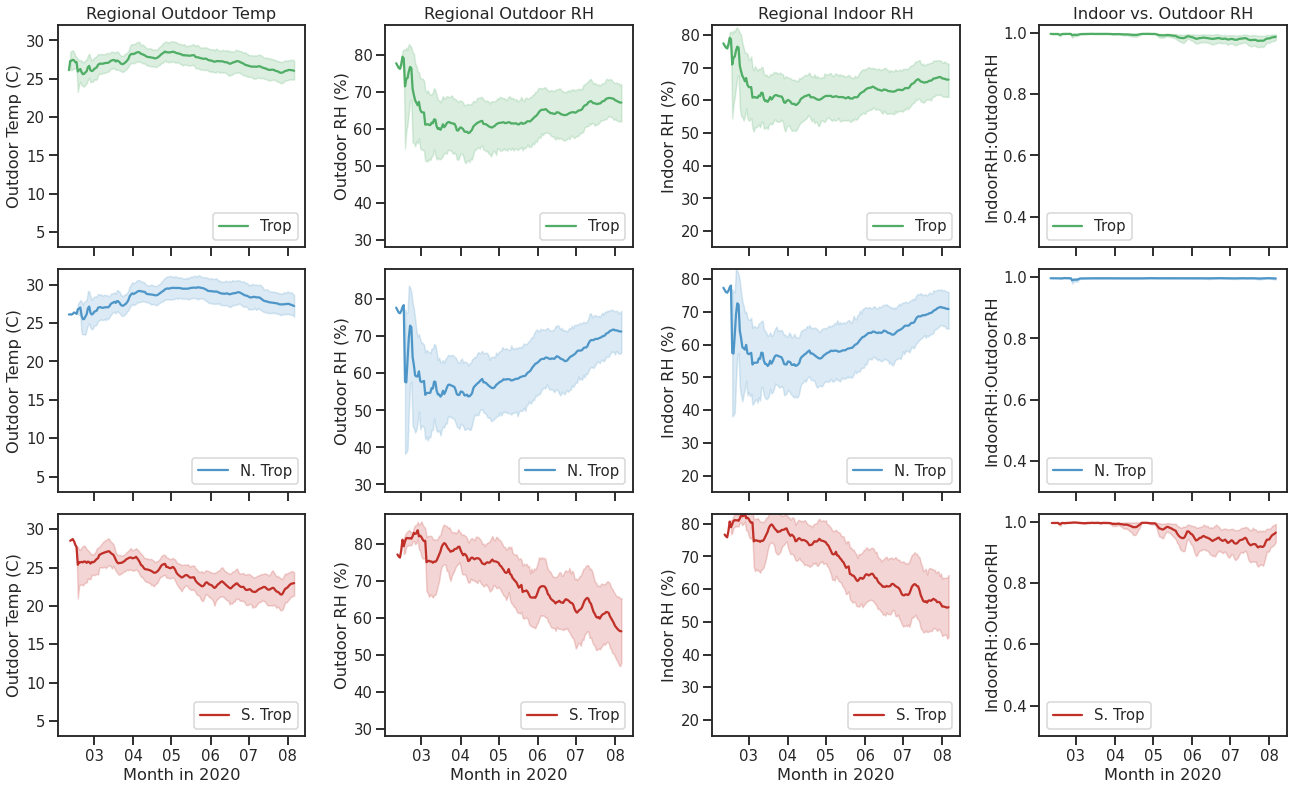

In [ ]:
fig,ax = plt.subplots(3,4,sharex='col',sharey='col',figsize=(18,11))

df7all['Date']=pd.to_datetime(df7all['Date'])

sns.lineplot(x='Date',y='DailyTemp_C',data=df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))],ax=ax[0,0],legend=False,color=sns.color_palette(palette='Greens_d',n_colors=4)[1],label='Trop'); #sns.despine()
sns.lineplot(x='Date',y='DailyRH_pct',data=df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))],ax=ax[0,1],legend=False,color=sns.color_palette(palette='Greens_d',n_colors=4)[1],label='Trop'); #sns.despine()
sns.lineplot(x='Date',y='IndoorRH_pct',data=df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))],ax=ax[0,2],legend=False,color=sns.color_palette(palette='Greens_d',n_colors=4)[1],label='Trop'); #sns.despine()
sns.lineplot(x=df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))]['Date'],y=df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))]['IndoorRH_pct']/df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))]['DailyRH_pct'],ax=ax[0,3],color=sns.color_palette(palette='Greens_d',n_colors=4)[1],label='Trop'); #sns.despine()

sns.lineplot(x='Date',y='DailyTemp_C',data=df7all[df7all['Country'].isin(n_trop['Country'].unique())],ax=ax[1,0],legend=False,color=sns.color_palette(palette='Blues_d',n_colors=4)[1],label='N. Trop'); #sns.despine()
sns.lineplot(x='Date',y='DailyRH_pct',data=df7all[df7all['Country'].isin(n_trop['Country'].unique())],ax=ax[1,1],legend=False,color=sns.color_palette(palette='Blues_d',n_colors=4)[1],label='N. Trop'); #sns.despine()
sns.lineplot(x='Date',y='IndoorRH_pct',data=df7all[df7all['Country'].isin(n_trop['Country'].unique())],ax=ax[1,2],legend=False,color=sns.color_palette(palette='Blues_d',n_colors=4)[1],label='N. Trop'); #sns.despine()
sns.lineplot(x=df7all[df7all['Country'].isin(n_trop['Country'].unique())]['Date'],y=df7all[df7all['Country'].isin(n_trop['Country'].unique())]['IndoorRH_pct']/df7all[df7all['Country'].isin(n_trop['Country'].unique())]['DailyRH_pct'],ax=ax[1,3],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],label='N. Trop'); #sns.despine()

sns.lineplot(x='Date',y='DailyTemp_C',data=df7all[df7all['Country'].isin(s_trop['Country'].unique())],ax=ax[2,0],legend=False,color=sns.color_palette(palette='Reds_d',n_colors=4)[2],label='S. Trop'); #sns.despine()
sns.lineplot(x='Date',y='DailyRH_pct',data=df7all[df7all['Country'].isin(s_trop['Country'].unique())],ax=ax[2,1],legend=False,color=sns.color_palette(palette='Reds_d',n_colors=4)[2],label='S. Trop'); #sns.despine()
sns.lineplot(x='Date',y='IndoorRH_pct',data=df7all[df7all['Country'].isin(s_trop['Country'].unique())],ax=ax[2,2],legend=False,color=sns.color_palette(palette='Reds_d',n_colors=4)[2],label='S. Trop'); #sns.despine()
sns.lineplot(x=df7all[df7all['Country'].isin(s_trop['Country'].unique())]['Date'],y=df7all[df7all['Country'].isin(s_trop['Country'].unique())]['IndoorRH_pct']/df7all[df7all['Country'].isin(s_trop['Country'].unique())]['DailyRH_pct'],ax=ax[2,3],color=sns.color_palette(palette='Reds_d',n_colors=4)[2],label='S. Trop'); #sns.despine()

[ax.xaxis_date() for ax in plt.gcf().axes]

# Place legends 
[ax[0,c].legend(loc='lower right') for c in np.arange(0,3)]
[ax[1,c].legend(loc='lower right') for c in np.arange(0,3)]
[ax[2,c].legend(loc='lower right') for c in np.arange(0,3)]

# Define Y axis limits 
[ax[r,0].set_ylim(3,32) for r in np.arange(0,3)]; [ax[r,1].set_ylim(28,88) for r in np.arange(0,3)]; [ax[r,2].set_ylim(15,83) for r in np.arange(0,3)]; [ax[r,3].set_ylim(0.3,1.025) for r in np.arange(0,3)]

#ax[0,1].set_ylim(28,88); ax[0,2].set_ylim(15,83); ax[0,3].set_ylim(0.3,1.05)

# Define Y axis labels 
[ax[r,0].set_ylabel('Outdoor Temp (C)') for r in np.arange(0,3)]; 
[ax[r,1].set_ylabel('Outdoor RH (%)') for r in np.arange(0,3)]; 
[ax[r,2].set_ylabel('Indoor RH (%)') for r in np.arange(0,3)]; 
[ax[r,3].set_ylabel('IndoorRH:OutdoorRH') for r in np.arange(0,3)]; 

# Define X axis labels 
ax[2,0].set_xlabel('Month in 2020'); ax[2,1].set_xlabel('Month in 2020'); ax[2,2].set_xlabel('Month in 2020'); ax[2,3].set_xlabel('Month in 2020')

ax[0,0].set_title('Regional Outdoor Temp')
ax[0,1].set_title('Regional Outdoor RH')
ax[0,2].set_title('Regional Indoor RH')
ax[0,3].set_title('Indoor vs. Outdoor RH')

import matplotlib.dates as md
[ax.xaxis.set_major_formatter(md.DateFormatter('%m')) for ax in plt.gcf().axes]
#[ax.tick_params(axis='x',labelrotation=20) for ax in plt.gcf().axes]
#fig.tight_layout()
fig.tight_layout(pad=0.5, w_pad=1.5, h_pad=0.8)

# from google.colab import files
# filename = ('Supplemental_SensitivityAnalysis_WeatherTimeseries_NorthTropics_SouthTropics.png').format(firstday=first_day,lastday=last_day)
# fig.savefig(filename, dpi=500)
# files.download(filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

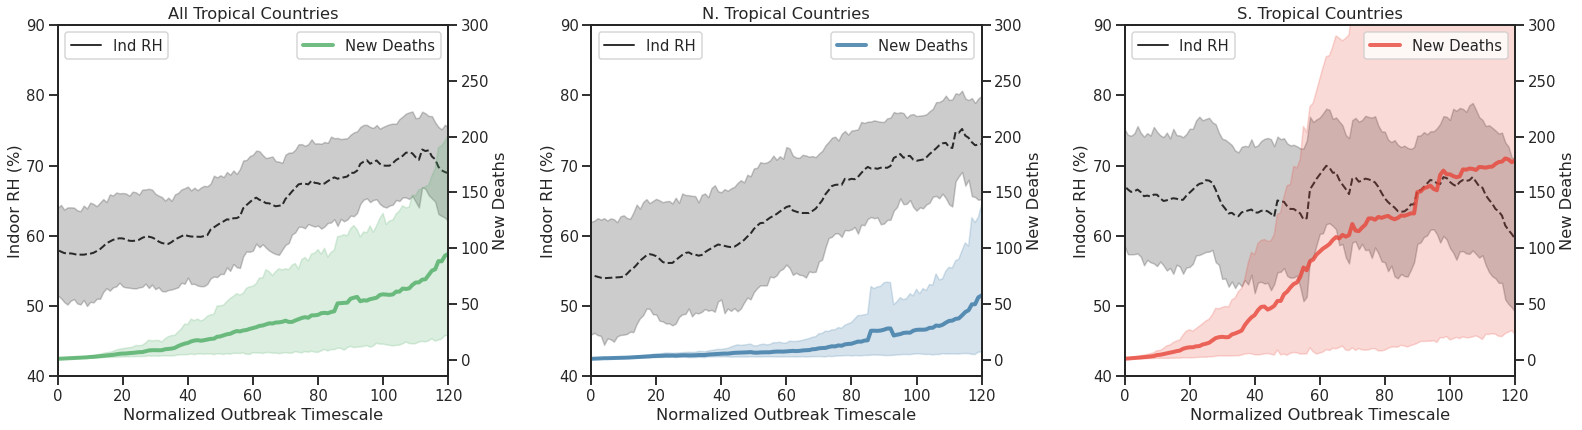

In [ ]:
# Compare new deaths and indoor climate 

fig,ax = plt.subplots(1,3,figsize=(22,6))

# N. Hemisphere 
ax0 = ax[0].twinx()
sns.lineplot(x='Days From 5th Death',y='IndoorRH_pct',data=df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))],ax=ax[0],label='Ind RH',color='black',linewidth=2,alpha=0.8)#,style=True,dashes=[(2,2)])
sns.lineplot(x='Days From 5th Death',y='new_deaths',data=df7all[df7all['Country'].isin(np.append(n_trop['Country'].unique(), s_trop['Country'].unique()))],ax=ax0,label='New Deaths',color=sns.color_palette(palette='Greens_d',n_colors=4)[1],linewidth=4,alpha=0.8)
ax[0].set_ylim(40,90)
ax0.set_ylim(-15,300)
ax[0].legend(loc='upper left')
ax0.legend(loc='upper right')
ax[0].lines[0].set_linestyle("--")

# S. Hemisphere 
ax1 = ax[1].twinx()
sns.lineplot(x='Days From 5th Death',y='IndoorRH_pct',data=df7all[df7all['Country'].isin(n_trop['Country'].unique())],ax=ax[1],label='Ind RH',color='black',linewidth=2,alpha=0.8)
sns.lineplot(x='Days From 5th Death',y='new_deaths',data=df7all[df7all['Country'].isin(n_trop['Country'].unique())],ax=ax1,label='New Deaths',color=sns.color_palette(palette='Blues_d',n_colors=4)[2],linewidth=4,alpha=0.8)
ax[1].set_ylim(40,90)
ax1.set_ylim(-15,300)
ax[1].legend(loc='upper left')
ax1.legend(loc='upper right')
ax[1].lines[0].set_linestyle("--")


# Trop
ax2 = ax[2].twinx()
sns.lineplot(x='Days From 5th Death',y='IndoorRH_pct',data=df7all[df7all['Country'].isin(s_trop['Country'].unique())],ax=ax[2],label='Ind RH',color='black',linewidth=2,alpha=0.8)
sns.lineplot(x='Days From 5th Death',y='new_deaths',data=df7all[df7all['Country'].isin(s_trop['Country'].unique())],ax=ax2,label='New Deaths',color=sns.color_palette(palette='Reds_d',n_colors=4)[1],linewidth=4,alpha=0.8)
ax[2].set_ylim(40,90)
ax2.set_ylim(-15,300)
ax[2].legend(loc='upper left')
ax2.legend(loc='upper right')
ax[2].lines[0].set_linestyle("--")


# Labels & Titles 
ax[0].set_title('All Tropical Countries'); ax[1].set_title('N. Tropical Countries'); ax[2].set_title('S. Tropical Countries')
ax[0].set_ylabel('Indoor RH (%)'); ax[1].set_ylabel('Indoor RH (%)'); ax[2].set_ylabel('Indoor RH (%)')
ax0.set_ylabel('New Deaths'); ax1.set_ylabel('New Deaths'); ax2.set_ylabel('New Deaths')

[ax.set_xlabel('Normalized Outbreak Timescale') for ax in plt.gcf().axes]
[ax.set_xlim(0,120) for ax in plt.gcf().axes]
fig.tight_layout(pad=0.5, w_pad=2, h_pad=0.8)

from google.colab import files
filename = ('Supplemental_SensitivityAnalysis_RHvsDeathsTimeseries_NorthTropics_SouthTropics.png').format(firstday=first_day,lastday=last_day)
fig.savefig(filename, dpi=500)
files.download(filename) 